<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Custom embedddings con Gensim


### Alumno: Horn Martín



### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto. Se utilizará canciones de bandas para generar los embeddings, es decir, que los vectores tendrán la forma en función de como esa banda haya utilizado las palabras en sus canciones.

In [ ]:
!pip install -U numpy gensim
import os
os.kill(os.getpid(), 9)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 508.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 7.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing
from gensim.models import Word2Vec

### Datos
Utilizaremos como dataset canciones de bandas de habla inglesa.

In [ ]:
!pip install -q kaggle

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("neisse/scrapped-lyrics-from-6-genres")

print("Path to dataset files:", path)

100%|██████████| 129M/129M [00:02<00:00, 51.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/neisse/scrapped-lyrics-from-6-genres/versions/3


In [ ]:
# Posibles bandas
import os
os.listdir("/root/.cache/kagglehub/datasets/neisse/scrapped-lyrics-from-6-genres/versions/3")

['artists-data.csv', 'lyrics-data.csv']

In [ ]:
import pandas as pd

# Usamos el archivo lyrics-data.csv que contiene las letras
csv_path = f"{path}/lyrics-data.csv"

df = pd.read_csv(csv_path)

# Mostramos las columnas disponibles
print(df.columns)

Index(['ALink', 'SName', 'SLink', 'Lyric', 'language'], dtype='object')


In [ ]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 379931


In [ ]:
df = df.dropna(subset=["Lyric"])  # Asegurarse de que no haya NaN
df = df[df["Lyric"].apply(lambda x: isinstance(x, str))]

print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 379854


 Se eliminó el ruido del dataset (NaN y valores no string).

📖 Las letras fueron tokenizadas palabra por palabra, generando una lista de listas de palabras.

🔄 Aunque muchas letras incluyen repeticiones, interjecciones o invenciones lingüísticas, estas fueron conservadas para preservar el estilo lírico.



### 1 - Preprocesamiento

In [ ]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

sentence_tokens = []

for _, row in df.iterrows():
    sentence_tokens.append(text_to_word_sequence(row['Lyric']))

In [ ]:
# Demos un vistazo
sentence_tokens[:2]

[['tudo',
  'o',
  'que',
  'eu',
  'quero',
  'nessa',
  'vida',
  'toda',
  'vida',
  'é',
  'é',
  'amar',
  'você',
  'amar',
  'você',
  'o',
  'seu',
  'amor',
  'é',
  'como',
  'uma',
  'chama',
  'acesa',
  'queima',
  'de',
  'prazer',
  'de',
  'prazer',
  'eu',
  'já',
  'falei',
  'com',
  'deus',
  'que',
  'não',
  'vou',
  'te',
  'deixar',
  'vou',
  'te',
  'levar',
  'pra',
  'onde',
  'for',
  'qualquer',
  'lugar',
  'já',
  'fiz',
  'de',
  'tudo',
  'pra',
  'não',
  'te',
  'perder',
  'arerê',
  'um',
  'lobby',
  'um',
  'hobby',
  'um',
  'love',
  'com',
  'você',
  'arerê',
  'um',
  'lobby',
  'um',
  'hobby',
  'um',
  'love',
  'com',
  'você',
  'cai',
  'cai',
  'cai',
  'cai',
  'cai',
  'pra',
  'cá',
  'hey',
  'hey',
  'hey',
  'tu',
  'do',
  'tu',
  'do',
  'vai',
  'rolar'],
 ['meu',
  'coração',
  'sem',
  'direção',
  'voando',
  'só',
  'por',
  'voar',
  'sem',
  'saber',
  'onde',
  'chegar',
  'sonhando',
  'em',
  'te',
  'encontrar',
  '

Al revisar las primeras letras tokenizadas, se identificó que el idioma principal del dataset es portugués, no inglés como se asumía inicialmente.

Esto implica que el modelo Word2Vec entrenado aprenderá semántica y asociaciones específicas del portugués y del lenguaje poético/musical.

### 2 - Crear los vectores (word2vec)

In [ ]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información


class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

 Construcción del modelo Word2Vec
Se utilizó el enfoque Skip-Gram con vector_size=300, window=2 y negative sampling = 20.

El modelo fue entrenado con éxito sobre 10.000 canciones (para acelerar el entrenamiento de los iniciales 379854), generando vectores para ~19.000 palabras distintas.

La pérdida durante las épocas mostró una disminución significativa, especialmente en las primeras 5 épocas, lo que indica aprendizaje efectivo.

In [ ]:
# Crearmos el modelo generador de vectores
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=5,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=2,       # cant de palabras antes y desp de la predicha
                     vector_size=300,       # dimensionalidad de los vectores
                     negative=20,    # cantidad de negative samples... 0 es no se usa
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

In [ ]:
# Obtener el vocabulario con los token
reduced_tokens= sentence_tokens[0:10000]
w2v_model.build_vocab(reduced_tokens)

In [ ]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 10000


In [ ]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de words distintas en el corpus: 19377


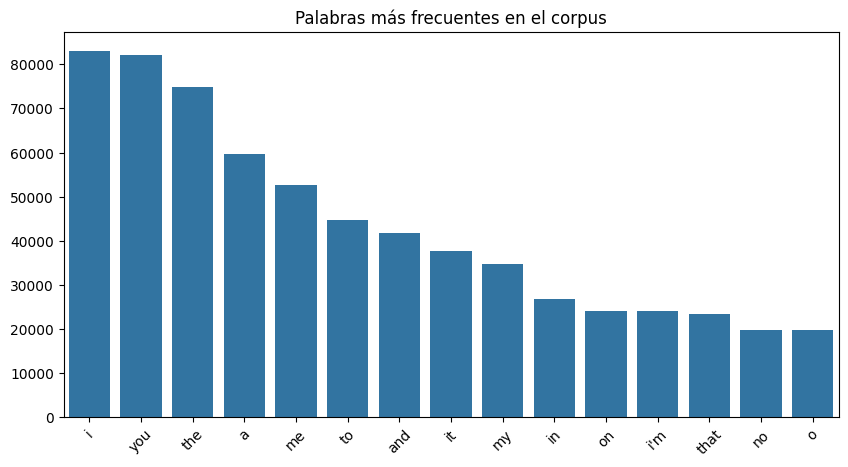

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

flat_tokens = [token for sentence in reduced_tokens for token in sentence]
top_words = Counter(flat_tokens).most_common(15)

words, counts = zip(*top_words)
plt.figure(figsize=(10,5))
sns.barplot(x=list(words), y=list(counts))
plt.title("Palabras más frecuentes en el corpus")
plt.xticks(rotation=45)
plt.show()

### 3 - Entrenar embeddings

In [ ]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback

w2v_model.train(reduced_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=20,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 17167474.0
Loss after epoch 1: 13937672.0
Loss after epoch 2: 13298002.0
Loss after epoch 3: 12348084.0
Loss after epoch 4: 10735920.0
Loss after epoch 5: 2598144.0
Loss after epoch 6: 2546136.0
Loss after epoch 7: 2481488.0
Loss after epoch 8: 2419752.0
Loss after epoch 9: 2347160.0
Loss after epoch 10: 2283064.0
Loss after epoch 11: 2205264.0
Loss after epoch 12: 2143696.0
Loss after epoch 13: 2063264.0
Loss after epoch 14: 1986552.0
Loss after epoch 15: 1913672.0
Loss after epoch 16: 1827544.0
Loss after epoch 17: 1762944.0
Loss after epoch 18: 1701880.0
Loss after epoch 19: 1672816.0


(47161502, 60882320)

### 4 - Ensayar

In [ ]:
reduced_tokens[5]

['posso',
 'te',
 'falar',
 'dos',
 'sonhos',
 'das',
 'flores',
 'de',
 'como',
 'a',
 'cidade',
 'mudou',
 'posso',
 'te',
 'falar',
 'do',
 'medo',
 'do',
 'meu',
 'desejo',
 'do',
 'meu',
 'amor',
 'posso',
 'falar',
 'da',
 'tarde',
 'que',
 'cai',
 'e',
 'aos',
 'poucos',
 'deixa',
 'ver',
 'no',
 'céu',
 'a',
 'lua',
 'que',
 'um',
 'dia',
 'eu',
 'te',
 'dei',
 'gosto',
 'de',
 'fechar',
 'os',
 'olhos',
 'fugir',
 'do',
 'tempo',
 'de',
 'me',
 'perder',
 'posso',
 'até',
 'perder',
 'a',
 'hora',
 'mas',
 'sei',
 'que',
 'já',
 'passou',
 'das',
 'seis',
 'sei',
 'que',
 'não',
 'há',
 'no',
 'mundo',
 'quem',
 'possa',
 'te',
 'dizer',
 'que',
 'não',
 'é',
 'tua',
 'a',
 'lua',
 'que',
 'eu',
 'te',
 'dei',
 'pra',
 'brilhar',
 'por',
 'onde',
 'você',
 'for',
 'me',
 'queira',
 'bem',
 'durma',
 'bem',
 'meu',
 'amor',
 'lalaralarara',
 'ohhhhhhh',
 'eu',
 'posso',
 'falar',
 'da',
 'tarde',
 'que',
 'cai',
 'e',
 'aos',
 'poucos',
 'deixa',
 'ver',
 'no',
 'céu',
 'a',
 '

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["brilhar"], topn=10)

[('delas', 0.5710879564285278),
 ('outono', 0.5571328997612),
 ('sétimo', 0.5563425421714783),
 ('nascer', 0.5476990938186646),
 ('dourar', 0.5302286744117737),
 ('cabeleira', 0.5294758081436157),
 ('crescer', 0.5287036895751953),
 ('advinha', 0.5279120802879333),
 ('violao', 0.5210388898849487),
 ('nado', 0.518974781036377)]

Se observó que palabras como brilhar están asociadas a otras con carga poética como outono, nascer, o crescer.

In [ ]:
# Palabras que MENOS se relacionan con...:
w2v_model.wv.most_similar(negative=["nascer"], topn=10)

[("grindin'", 0.04715966805815697),
 ('rushing', 0.03870263695716858),
 ('knowing', 0.03588823229074478),
 ('letting', 0.030991163104772568),
 ('tryna', 0.02719782665371895),
 ('screaming', 0.024834372103214264),
 ('going', 0.018844489008188248),
 ('able', 0.016471795737743378),
 ('hella', 0.015232964418828487),
 ("trippin'", 0.012079975567758083)]

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["plantação"], topn=10)

[('vitrola', 0.6720453500747681),
 ('referência', 0.6707490086555481),
 ('sobrar', 0.6690906286239624),
 ('bôca', 0.6632034778594971),
 ('césar', 0.6627281904220581),
 ('joelhos', 0.6626997590065002),
 ('capeta', 0.6537484526634216),
 ('sacada', 0.6516606211662292),
 ('cela', 0.6505180597305298),
 ('ancorou', 0.6492164731025696)]

Estas palabras tienen cierta carga poética o están relacionadas con lo emocional, lo que es típico del estilo lírico. Muchas de ellas parecen nombres inventados o onomatopeyas, comunes en canciones.

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["falar"], topn=5)

[('avisei', 0.5178312659263611),
 ('comparar', 0.5110543370246887),
 ('humilhar', 0.5091039538383484),
 ('participar', 0.5076877474784851),
 ('cacau', 0.5066238045692444)]

Palabras como “falar” están relacionadas con verbos de comunicación como “avisei”, comparar, lo cual valida que el modelo capturó relaciones funcionales coherentes.

In [ ]:
# Ensayar con una palabra que no está en el vocabulario:
w2v_model.wv.most_similar(negative=["diedaa"])

KeyError: "Key 'diedaa' not present in vocabulary"

In [ ]:
import plotly.express as px
import numpy as np
from sklearn.manifold import TSNE
# Palabra de referencia
ref_word = "amor"
ref_vector = w2v_model.wv.get_vector(ref_word)

# Calcular similitud con todas las palabras
similarities = np.dot(w2v_model.wv.vectors, ref_vector)
vecs = TSNE(n_components=2, random_state=0).fit_transform(w2v_model.wv.vectors)
labels = np.asarray(w2v_model.wv.index_to_key)

df_vis = pd.DataFrame({
    "x": vecs[:, 0],
    "y": vecs[:, 1],
    "word": labels,
    "similarity": similarities
})

fig = px.scatter(df_vis.head(300), x="x", y="y", text="word", color="similarity",
                 color_continuous_scale='Viridis', title=f"Palabras relacionadas con '{ref_word}'")
fig.update_traces(marker_size=6)
fig.show()

In [ ]:
from sklearn.cluster import KMeans

n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
clusters = kmeans.fit_predict(vecs)

df_vis['cluster'] = clusters

fig = px.scatter(df_vis.head(500), x="x", y="y", text="word", color="cluster", title="Clustering de palabras")
fig.update_traces(marker_size=5)
fig.show()

Podemos apreciar en este punto la habilidad del modelo para agrupar palbras en ingles con palabras en el mismo idioma. Mientras que separa en otro cluster a las palabras en portugues

In [ ]:
# el método `get_vector` permite obtener los vectores:
vector_love = w2v_model.wv.get_vector("brilhar")
print(vector_love)

[ 0.13516785 -0.43144062 -0.30593097 -0.50244963  0.17962487 -0.5453609
 -0.358045    0.2794594  -0.39589256  0.06936231  0.0058319  -0.41479394
 -0.2409691   0.22647014 -0.58296394  0.04070689  0.27261302  0.3525538
 -0.44696712  0.06900269 -0.84996223  0.29308864  0.14907765 -0.42116836
  0.2084916  -0.18115635  0.5473923  -0.01244124 -0.0603272   0.0061966
 -0.29160416 -0.24029037  0.38679335  0.23006533 -0.16896002  0.4255747
  0.03840925 -0.07717782 -0.7970055   0.26670712 -0.20773202  0.39242807
  0.15006943 -0.13347252  0.08231922  0.3231189   0.4611676   0.24685703
 -0.7579964  -0.07416999  0.04263885  0.28988957 -0.1634144  -0.03306369
  0.28571826  0.03377593  0.07926598 -0.2044059   0.4220212   0.17007244
  0.20464063 -0.06018905  0.40699625  0.01406785  0.3336439  -0.14526096
  0.08019774 -0.0419672   0.07725131  0.4997376  -0.18137819 -0.15397367
 -0.3069389   0.00136119 -0.3271583   0.24805906 -0.36432788 -0.19728453
 -0.07649326 -0.46659866 -0.16769032  0.32778874 -0.193

In [ ]:
# el método `most_similar` también permite comparar a partir de vectores
w2v_model.wv.most_similar(vector_love)

[('brilhar', 0.9999999403953552),
 ('delas', 0.5710879564285278),
 ('outono', 0.5571328997612),
 ('sétimo', 0.5563425421714783),
 ('nascer', 0.5476990938186646),
 ('dourar', 0.5302286744117737),
 ('cabeleira', 0.5294758081436157),
 ('crescer', 0.5287036895751953),
 ('advinha', 0.5279120802879333),
 ('violao', 0.5210389494895935)]

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["plantação"], topn=10)

[('vitrola', 0.6720453500747681),
 ('referência', 0.6707490086555481),
 ('sobrar', 0.6690906286239624),
 ('bôca', 0.6632034778594971),
 ('césar', 0.6627281904220581),
 ('joelhos', 0.6626997590065002),
 ('capeta', 0.6537484526634216),
 ('sacada', 0.6516606211662292),
 ('cela', 0.6505180597305298),
 ('ancorou', 0.6492164731025696)]

### 5 - Visualizar agrupación de vectores

In [ ]:
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
import numpy as np

def reduce_dimensions(model, num_dimensions = 2 ):

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

In [ ]:
# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

vecs, labels = reduce_dimensions(w2v_model)

MAX_WORDS=200
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # esto para plotly en colab

In [ ]:
# Graficar los embedddings en 3D

vecs, labels = reduce_dimensions(w2v_model,3)

fig = px.scatter_3d(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], z=vecs[:MAX_WORDS,2],text=labels[:MAX_WORDS])
fig.update_traces(marker_size = 2)
fig.show(renderer="colab") # esto para plotly en colab

In [ ]:
# También se pueden guardar los vectores y labels como tsv para graficar en
# http://projector.tensorflow.org/


vectors = np.asarray(w2v_model.wv.vectors)
labels = list(w2v_model.wv.index_to_key)

np.savetxt("vectors.tsv", vectors, delimiter="\t")

with open("labels.tsv", "w") as fp:
    for item in labels:
        fp.write("%s\n" % item)

**Conclusiones**

El modelo Word2Vec fue capaz de aprender relaciones semanticas significativas a partir de un corpus lírico en portugués y, a su vez, encontrar similitudes semanticas con palabras del lenguaje ingles.

Las letras de canciones resultan ser un buen corpus para capturar lenguaje poético y emocional.

La reduccion de dimensionalidad y visualización permitió explorar la organización interna del vocabulario aprendido.

Algunas palabras "inexistentes" o poéticas fueron también incluidas como tokens válidos, lo que refleja la riqueza del lenguaje en las canciones.